In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers



df = pd.read_csv('NVDA.csv')
df = df[['Date', 'Close']]
df


,Date,Close
0,2019-05-01,45.117500
1,2019-05-02,45.797501
2,2019-05-03,45.752499
3,2019-05-06,44.962502
4,2019-05-07,43.277500
...,...,...
1255,2024-04-25,826.320007
1256,2024-04-26,877.349976
1257,2024-04-29,877.570007
1258,2024-04-30,864.020020


In [2]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [3]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      2019-05-01
1      2019-05-02
2      2019-05-03
3      2019-05-06
4      2019-05-07
          ...    
1255   2024-04-25
1256   2024-04-26
1257   2024-04-29
1258   2024-04-30
1259   2024-05-01
Name: Date, Length: 1260, dtype: datetime64[ns]

In [4]:
df.index = df.pop('Date')
df

,Close
Date,
2019-05-01,45.117500
2019-05-02,45.797501
2019-05-03,45.752499
2019-05-06,44.962502
2019-05-07,43.277500
...,...
2024-04-25,826.320007
2024-04-26,877.349976
2024-04-29,877.570007


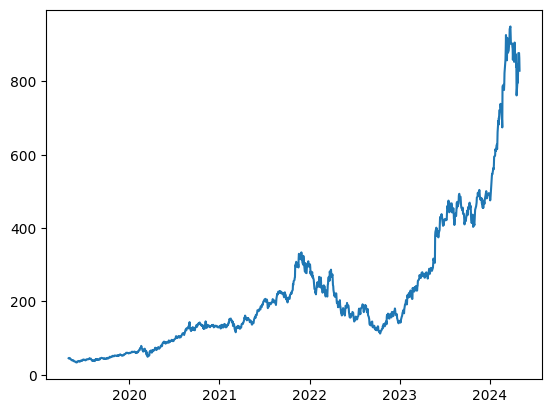

In [5]:
plt.plot(df.index, df['Close'])

In [43]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-05-01', 
                                '2023-05-01', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-05-01,153.817505,152.767502,153.247498,150.095001
1,2021-05-04,153.247498,150.095001,148.367493,143.512497
2,2021-05-05,150.095001,148.367493,143.512497,144.585007
3,2021-05-06,148.367493,143.512497,144.585007,145.229996
4,2021-05-07,143.512497,144.585007,145.229996,148.122498
...,...,...,...,...,...
498,2023-04-25,271.040009,271.190002,270.420013,262.410004
499,2023-04-26,271.190002,270.420013,262.410004,269.559998
500,2023-04-27,270.420013,262.410004,269.559998,272.260010
501,2023-04-28,262.410004,269.559998,272.260010,277.489990


In [44]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((503,), (503, 3, 1), (503,))

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2019-05-01 to 2024-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1260 non-null   float64
dtypes: float64(1)
memory usage: 52.0 KB


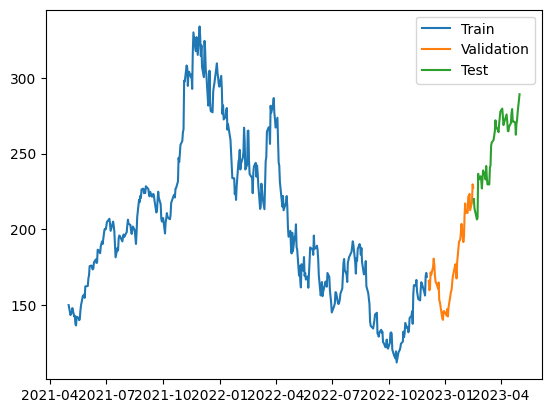

In [46]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.GRU(128, return_sequences=True),
                     layers.GRU(128),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 42040.6641 - mean_absolute_error: 198.4706 - val_loss: 29546.6992 - val_mean_absolute_error: 169.8758
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39638.4219 - mean_absolute_error: 191.4951 - val_loss: 25720.2695 - val_mean_absolute_error: 158.2161
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 34406.2773 - mean_absolute_error: 178.3295 - val_loss: 21330.5996 - val_mean_absolute_error: 143.6770
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30617.8652 - mean_absolute_error: 166.5341 - val_loss: 16149.4150 - val_mean_absolute_error: 124.3459
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 22967.5195 - mean_absolute_error: 141.9034 - val_loss: 10573.9727 - val_mean_absolute_error: 99.4309
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16105.1475 - mean_absolute_error: 115.0651 - val_loss: 5555.5464 - val_mean_absolute_error: 69.7717
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


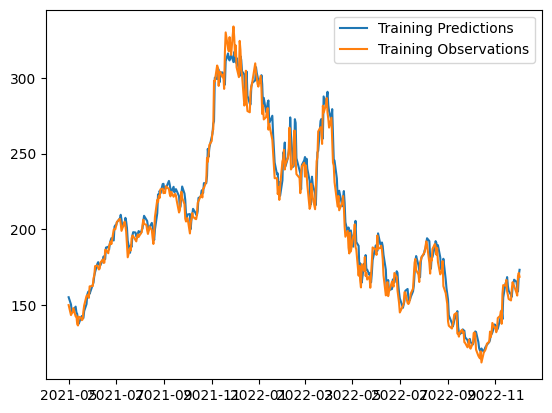

In [53]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


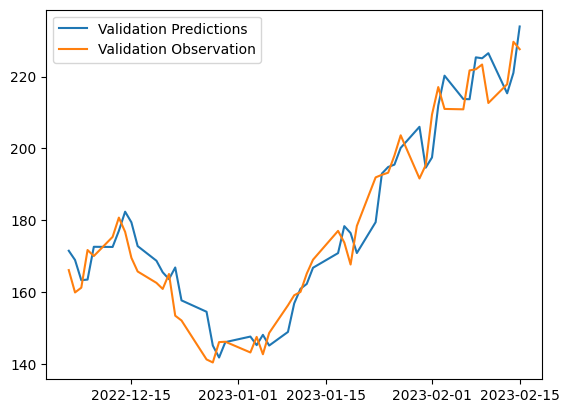

In [54]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observation'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


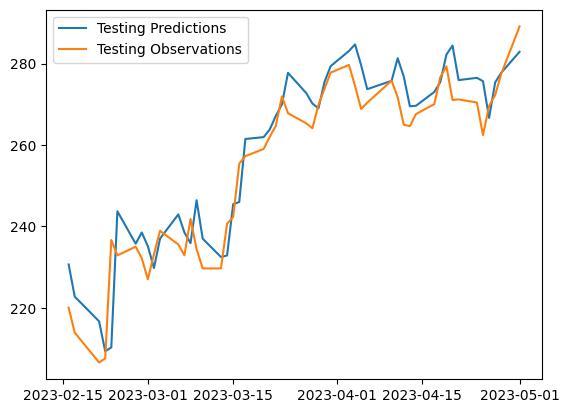

In [55]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])


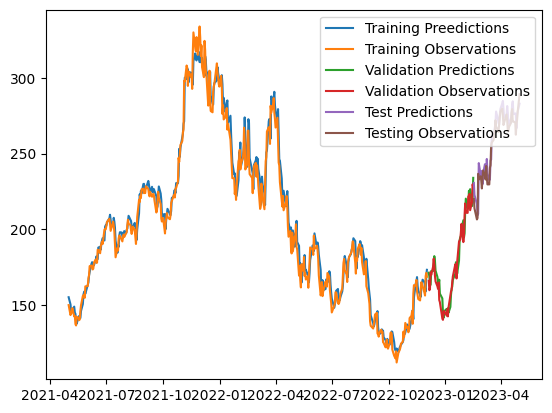

In [56]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Preedictions', 'Training Observations', 'Validation Predictions', 'Validation Observations', 'Test Predictions', 'Testing Observations'])

In [57]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
    last_window = deepcopy(X_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

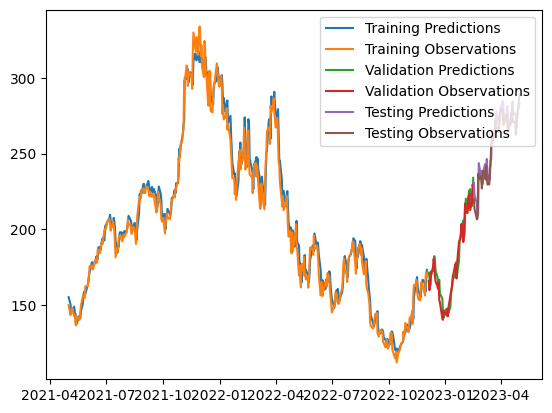

In [59]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
# plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            # 'Recursive Predictions'
            ])